<style>
    div{
        text-align: center;
    }
    h1{
        padding: 0;
        margin: 0;
        margin-bottom: 1rem;
        font-size: 6rem;
        font-weight: bold;
        background: linear-gradient(to right, rgb(67, 124, 205), rgb(69, 214, 202));
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
    }
</style>
<div>
    <h1>Object Detection</h1>
    <div>
        <b>Contributors</b>: Chloe Ren, Linbo Zhang, Tianyu Wei, Tommy Zhang, Yaxin Yuan
    </div>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL

<style>
    div{
        /* text-align: center; */
    }
    h2 {
        padding: 0;
        margin: 0;
        margin-bottom: 1rem;
        /* font-size: 6rem; */
        font-weight: bold;
        background: linear-gradient(to right, rgb(67, 124, 205), rgb(69, 214, 202));
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
    }
</style>
<div>
    <h2>Project Setups</h2>
</div>

In [6]:
# ref: https://www.kaggle.com/code/awsaf49/great-barrier-reef-yolov5-train/notebook

!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
%pip install -qr requirements.txt


# check installation
from yolov5 import utils
display = utils.notebook_init()

%cd ..

In [2]:

# constants

# paths
EXPORT_DIR = './dataset/'

TRAIN_DIR = EXPORT_DIR + 'train/'
TRAIN_EXPORT_IMAGE_DIR = TRAIN_DIR + 'images/'
TRAIN_EXPORT_LABEL_DIR = TRAIN_DIR + 'labels/'

VALID_DIR = EXPORT_DIR + 'valid/'
VALID_EXPORT_IMAGE_DIR = VALID_DIR + 'images/'
VALID_EXPORT_LABEL_DIR = VALID_DIR + 'labels/'

IMPORT_DIR = './tensorflow-great-barrier-reef/'
IMPORT_IMAGE_DIR = IMPORT_DIR + 'train_images/'

# OPTIMIZE: read size from image insead of hard code
# image size
WIDTH = 1280
HEIGHT = 720
IMAGE_SIZE = (WIDTH, HEIGHT)

# remove data with no annotation
REMOVE_NO_ANNOTATION = True

# drop unwanted columns
DROP_COLUMNS = ['sequence', 'sequence_frame', 'image_id']

In [3]:
# read csv
df = pd.read_csv('tensorflow-great-barrier-reef/train.csv')
df.head(10)

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []
5         0     40258            5               5      0-5          []
6         0     40258            6               6      0-6          []
7         0     40258            7               7      0-7          []
8         0     40258            8               8      0-8          []
9         0     40258            9               9      0-9          []

In [9]:
# exclude image with no annotations
if REMOVE_NO_ANNOTATION:
    df = df[df['annotations'] != "[]"]

# drop unwanted columns
if DROP_COLUMNS:
    df = df.drop(columns=DROP_COLUMNS)

df[df['video_id'] == 2]

video_id  video_frame  \
18786         2         4718   
18787         2         4719   
18788         2         4720   
18789         2         4721   
18790         2         4722   
...         ...          ...   
23369         2        10628   
23370         2        10629   
23371         2        10630   
23372         2        10631   
23373         2        10632   

                                             annotations  
18786  [{'x': 227, 'y': 479, 'width': 42, 'height': 38}]  
18787  [{'x': 224, 'y': 489, 'width': 42, 'height': 38}]  
18788  [{'x': 220, 'y': 498, 'width': 42, 'height': 38}]  
18789  [{'x': 217, 'y': 508, 'width': 42, 'height': 38}]  
18790  [{'x': 211, 'y': 517, 'width': 36, 'height': 38}]  
...                                                  ...  
23369   [{'x': 92, 'y': 532, 'width': 40, 'height': 37}]  
23370   [{'x': 78, 'y': 569, 'width': 40, 'height': 37}]  
23371   [{'x': 65, 'y': 606, 'width': 41, 'height': 37}]  
23372   [{'x': 51, 'y': 643, 'width': 44, 'height': 37}]  
23373   [{'x': 38, 'y': 681, 'width': 46, 'height': 37}]  

[677 rows x 3 columns]

In [10]:
def export_image_dir(x):
    if x.video_id == 2:
        return f"{VALID_EXPORT_IMAGE_DIR}{x.vid}.jpg"
    return f"{TRAIN_EXPORT_IMAGE_DIR}{x.vid}.jpg"

def export_label_dir(x):
    if x.video_id == 2:
        return f"{VALID_EXPORT_LABEL_DIR}{x.vid}.txt"
    return f"{TRAIN_EXPORT_LABEL_DIR}{x.vid}.txt"


# generate export file paths
df = df.reset_index().drop(columns=['index'])
df.reset_index(inplace=True)
df['vid'] = df['index']
df['export_image_path'] = df.apply(export_image_dir, axis=1)
df['export_label_path'] = df.apply(export_label_dir, axis=1)

df.set_index('index', drop=True, inplace=True)
df

video_id  video_frame  \
index                          
0             0           16   
1             0           17   
2             0           18   
3             0           19   
4             0           20   
...         ...          ...   
4914          2        10628   
4915          2        10629   
4916          2        10630   
4917          2        10631   
4918          2        10632   

                                             annotations   vid  \
index                                                            
0      [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]     0   
1      [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]     1   
2      [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]     2   
3      [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]     3   
4      [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]     4   
...                                                  ...   ...   
4914    [{'x': 92, 'y': 532, 'width': 40, 'height': 37}]  4914   
4915    [{'x': 78, 'y': 569, 'width': 40, 'height': 37}]  4915   
4916    [{'x': 65, 'y': 606, 'width': 41, 'height': 37}]  4916   
4917    [{'x': 51, 'y': 643, 'width': 44, 'height': 37}]  4917   
4918    [{'x': 38, 'y': 681, 'width': 46, 'height': 37}]  4918   

                     export_image_path                export_label_path  
index                                                                    
0         ./dataset/train/images/0.jpg     ./dataset/train/labels/0.txt  
1         ./dataset/train/images/1.jpg     ./dataset/train/labels/1.txt  
2         ./dataset/train/images/2.jpg     ./dataset/train/labels/2.txt  
3         ./dataset/train/images/3.jpg     ./dataset/train/labels/3.txt  
4         ./dataset/train/images/4.jpg     ./dataset/train/labels/4.txt  
...                                ...                              ...  
4914   ./dataset/valid/images/4914.jpg  ./dataset/valid/labels/4914.txt  
4915   ./dataset/valid/images/4915.jpg  ./dataset/valid/labels/4915.txt  
4916   ./dataset/valid/images/4916.jpg  ./dataset/valid/labels/4916.txt  
4917   ./dataset/valid/images/4917.jpg  ./dataset/valid/labels/4917.txt  
4918   ./dataset/valid/images/4918.jpg  ./dataset/valid/labels/4918.txt  

[4919 rows x 6 columns]

In [11]:
def f(video_id, video_frame):
    return f"video_{video_id}/{video_frame}.jpg"
    
df['import_image_path'] = df.apply(lambda x: f(x.video_id, x.video_frame), axis=1)
df

video_id  video_frame  \
index                          
0             0           16   
1             0           17   
2             0           18   
3             0           19   
4             0           20   
...         ...          ...   
4914          2        10628   
4915          2        10629   
4916          2        10630   
4917          2        10631   
4918          2        10632   

                                             annotations   vid  \
index                                                            
0      [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]     0   
1      [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]     1   
2      [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]     2   
3      [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]     3   
4      [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]     4   
...                                                  ...   ...   
4914    [{'x': 92, 'y': 532, 'width': 40, 'height': 37}]  4914   
4915    [{'x': 78, 'y': 569, 'width': 40, 'height': 37}]  4915   
4916    [{'x': 65, 'y': 606, 'width': 41, 'height': 37}]  4916   
4917    [{'x': 51, 'y': 643, 'width': 44, 'height': 37}]  4917   
4918    [{'x': 38, 'y': 681, 'width': 46, 'height': 37}]  4918   

                     export_image_path                export_label_path  \
index                                                                     
0         ./dataset/train/images/0.jpg     ./dataset/train/labels/0.txt   
1         ./dataset/train/images/1.jpg     ./dataset/train/labels/1.txt   
2         ./dataset/train/images/2.jpg     ./dataset/train/labels/2.txt   
3         ./dataset/train/images/3.jpg     ./dataset/train/labels/3.txt   
4         ./dataset/train/images/4.jpg     ./dataset/train/labels/4.txt   
...                                ...                              ...   
4914   ./dataset/valid/images/4914.jpg  ./dataset/valid/labels/4914.txt   
4915   ./dataset/valid/images/4915.jpg  ./dataset/valid/labels/4915.txt   
4916   ./dataset/valid/images/4916.jpg  ./dataset/valid/labels/4916.txt   
4917   ./dataset/valid/images/4917.jpg  ./dataset/valid/labels/4917.txt   
4918   ./dataset/valid/images/4918.jpg  ./dataset/valid/labels/4918.txt   

       import_image_path  
index                     
0         video_0/16.jpg  
1         video_0/17.jpg  
2         video_0/18.jpg  
3         video_0/19.jpg  
4         video_0/20.jpg  
...                  ...  
4914   video_2/10628.jpg  
4915   video_2/10629.jpg  
4916   video_2/10630.jpg  
4917   video_2/10631.jpg  
4918   video_2/10632.jpg  

[4919 rows x 7 columns]

In [12]:
# convert annotation string literals to python objects
df['annotations'] = df['annotations'].apply(eval)

In [13]:
# create directories to store train data in YOLOv5 PyTorch TXT formats
!mkdir dataset
%cd dataset
!mkdir train
%cd train
!mkdir images
!mkdir labels
%cd ..
!mkdir valid
%cd valid
!mkdir images
!mkdir labels
%cd ..
%cd ..

c:\Users\a2822\Downloads\UNSW\Comp9517\Group\Yolo5\dataset


A subdirectory or file dataset already exists.


c:\Users\a2822\Downloads\UNSW\Comp9517\Group\Yolo5\dataset\train


A subdirectory or file train already exists.
A subdirectory or file images already exists.


c:\Users\a2822\Downloads\UNSW\Comp9517\Group\Yolo5\dataset


A subdirectory or file labels already exists.


c:\Users\a2822\Downloads\UNSW\Comp9517\Group\Yolo5\dataset\valid


A subdirectory or file valid already exists.
A subdirectory or file images already exists.


c:\Users\a2822\Downloads\UNSW\Comp9517\Group\Yolo5\dataset
c:\Users\a2822\Downloads\UNSW\Comp9517\Group\Yolo5


A subdirectory or file labels already exists.


<style>
    div{
        /* text-align: center; */
    }
    h2 {
        padding: 0;
        margin: 0;
        margin-bottom: 1rem;
        /* font-size: 6rem; */
        font-weight: bold;
        background: linear-gradient(to right, rgb(67, 124, 205), rgb(69, 214, 202));
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
    }
</style>
<div>
    <h2>Image Preprocessing</h2>
</div>

In [14]:
# read images
imgs = [PIL.Image.open(IMPORT_IMAGE_DIR + row.import_image_path) for _, row in df.iterrows()]

c:\Users\a2822\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


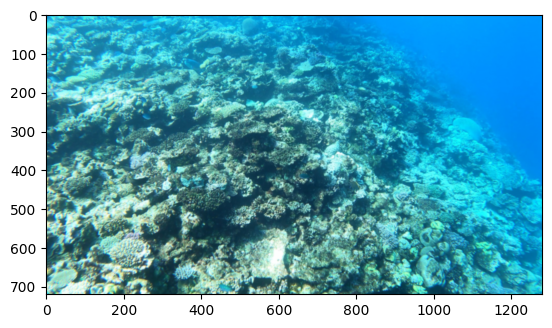

In [15]:
#  image preprocessing
from skimage.filters._gaussian import gaussian

img = np.array(imgs[0])

new_image = gaussian(img, sigma=1)

plt.imshow(new_image)

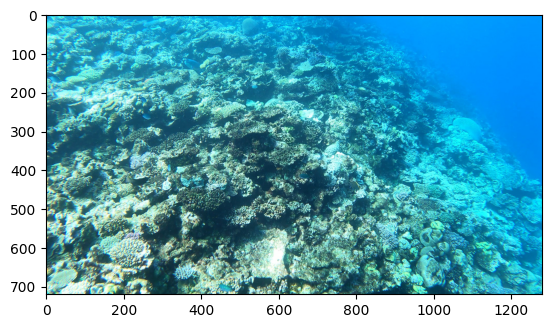

In [16]:
plt.imshow(img)

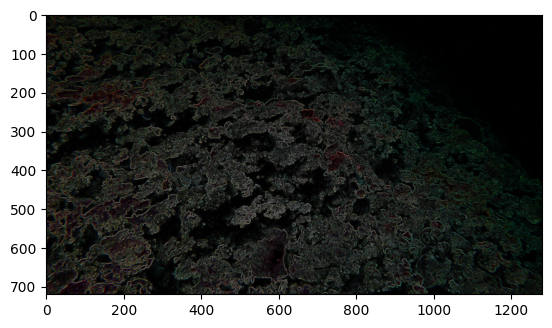

In [17]:
from skimage.filters import sobel


shape = img.shape

img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]
img_r = sobel(img_r)
img_g = sobel(img_g)
img_b = sobel(img_b)
# plt.imshow(sobel(img_r))
# plt.imshow(sobel(img_g))
# plt.imshow(sobel(img_b))

merged_image = np.stack([img_r.flatten(), img_g.flatten(), img_b.flatten()], axis=1).reshape(shape)
plt.imshow(merged_image)

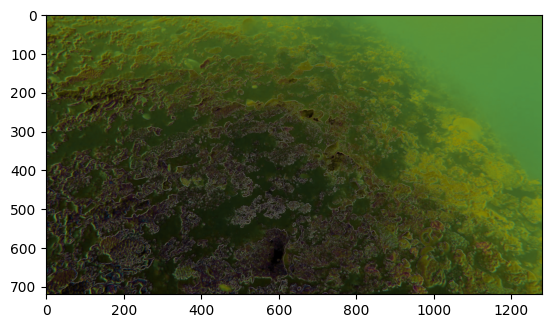

In [18]:
plt.imshow(sobel(img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


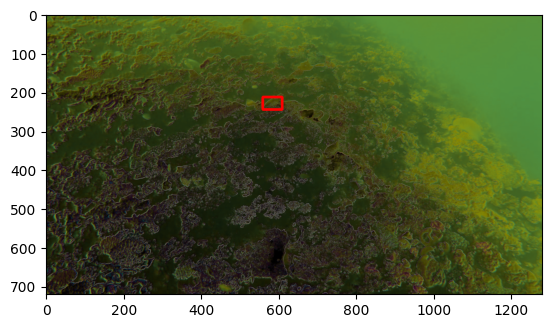

In [19]:
open_cv_image = img[:, :, ::-1].copy() 
rec = cv2.rectangle(sobel(img), (559,213), (609,245), (255, 0, 0), 5)
plt.imshow(rec)

In [20]:
# image to gray scale

from PIL import ImageOps

gray_image = ImageOps.grayscale(imgs[0])
gray_image.show()

In [21]:
np_gray = np.array(gray_image)

var_a = 0
var_b = 255

var_c = np_gray.min()
var_d = np_gray.max()

display(f"{var_a = :>5}")
display(f"{var_b = :>5}")
display(f"{var_c = :>5}")
display(f"{var_d = :>5}")


'var_a =     0'

'var_b =   255'

'var_c =    24'

'var_d =   255'

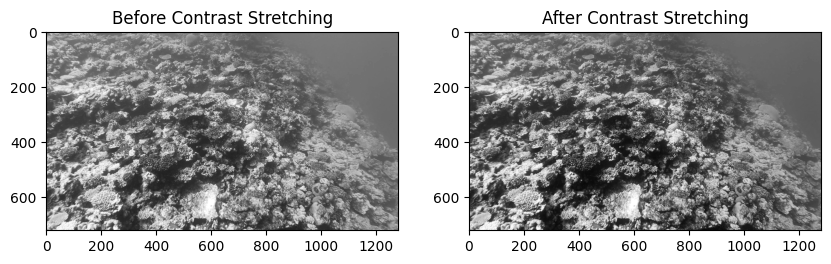

In [22]:
def output(i: int) -> float:
    return (i - var_c) * ((var_b - var_a) / (var_d - var_c)) + var_a

contrast = np.array([[output(x) for x in row] for row in np_gray])

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Before Contrast Stretching")
plt.imshow(np_gray, vmax=255, vmin=0, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("After Contrast Stretching")
plt.imshow(contrast, vmax=255, vmin=0, cmap='gray')


In [23]:
class KernalSizeException(Exception):
    ...


def padding_neighbours(matrix: np.ndarray, row: int, col: int, kernal_size: int = 3, padding_value: int = 0) -> list[int | float]:
    if kernal_size % 2 == 0:
        raise KernalSizeException("kernal size can only be odd number")

    max_height, max_weight = matrix.shape
    search_range = int(np.floor(kernal_size/2))
    neighbours = []

    for i in range(-search_range, search_range+1):
        for j in range(-search_range, search_range+1):
            row_index = row + i
            col_index = col + j
            if -1 < row_index < max_height and -1 < col_index < max_weight:
                neighbours.append(matrix[row_index, col_index])
            else:
                neighbours.append(padding_value)

    return neighbours

In [ ]:
row, col = contrast.shape
def f(N):
    
    image_A = np.zeros_like(contrast)

    for r in range(row):
        for c in range(col):
            image_A[r,c] = np.array(padding_neighbours(contrast, r, c, N, 255)).min()

    image_B = np.zeros_like(contrast)

    for r in range(row):
        for c in range(col):
            image_B[r,c] = np.array(padding_neighbours(image_A, r, c, N, 0)).max()
    
    return image_A, image_B

result = [f(N) for N in range(3, 14, 2)]

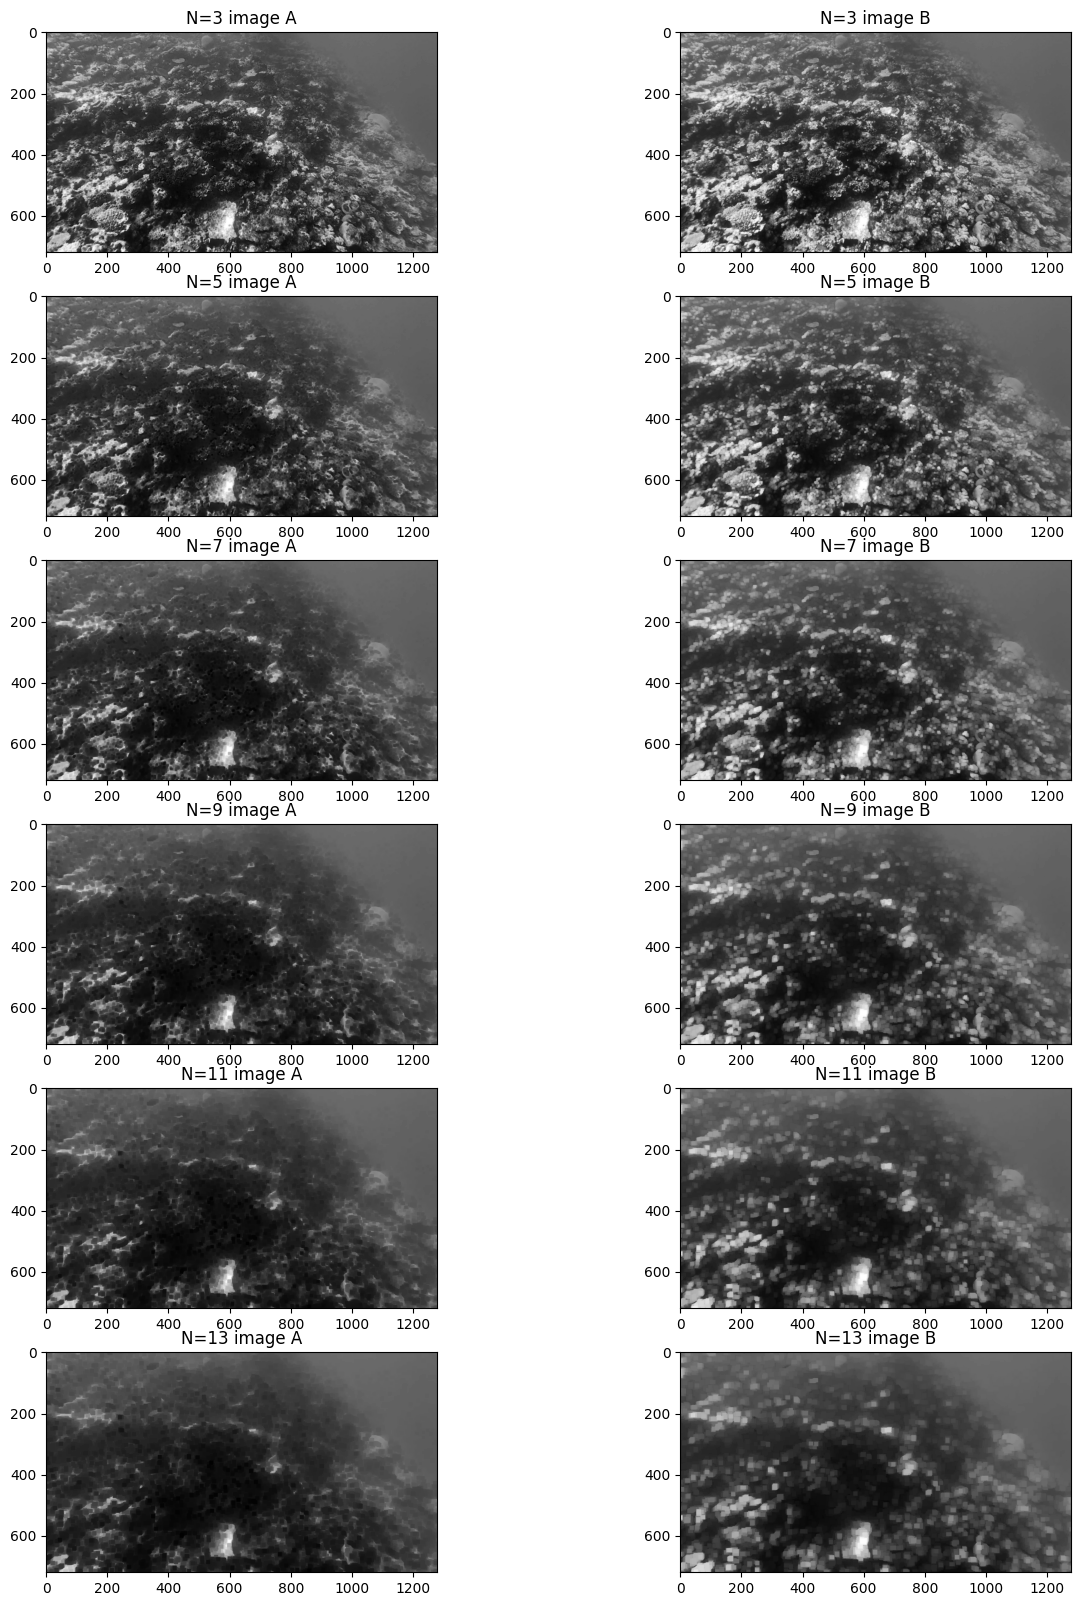

In [ ]:
fig = plt.figure(figsize=(15, 20))

index = 1
for images, N, index in zip(result, range(3, 14, 2), range(1, 13, 2)):
    img_A, img_B = images
    ax1 = fig.add_subplot(6, 2, index)
    ax1.set_title(f'{N=} image A')
    plt.imshow(img_A, cmap='gray', vmin=0, vmax=255)
    
    ax2 = fig.add_subplot(6, 2, index+1)
    ax2.set_title(f'{N=} image B')
    plt.imshow(img_B, cmap='gray', vmin=0, vmax=255)

In [ ]:
result = [f(N) for N in range(15, 30, 2)]

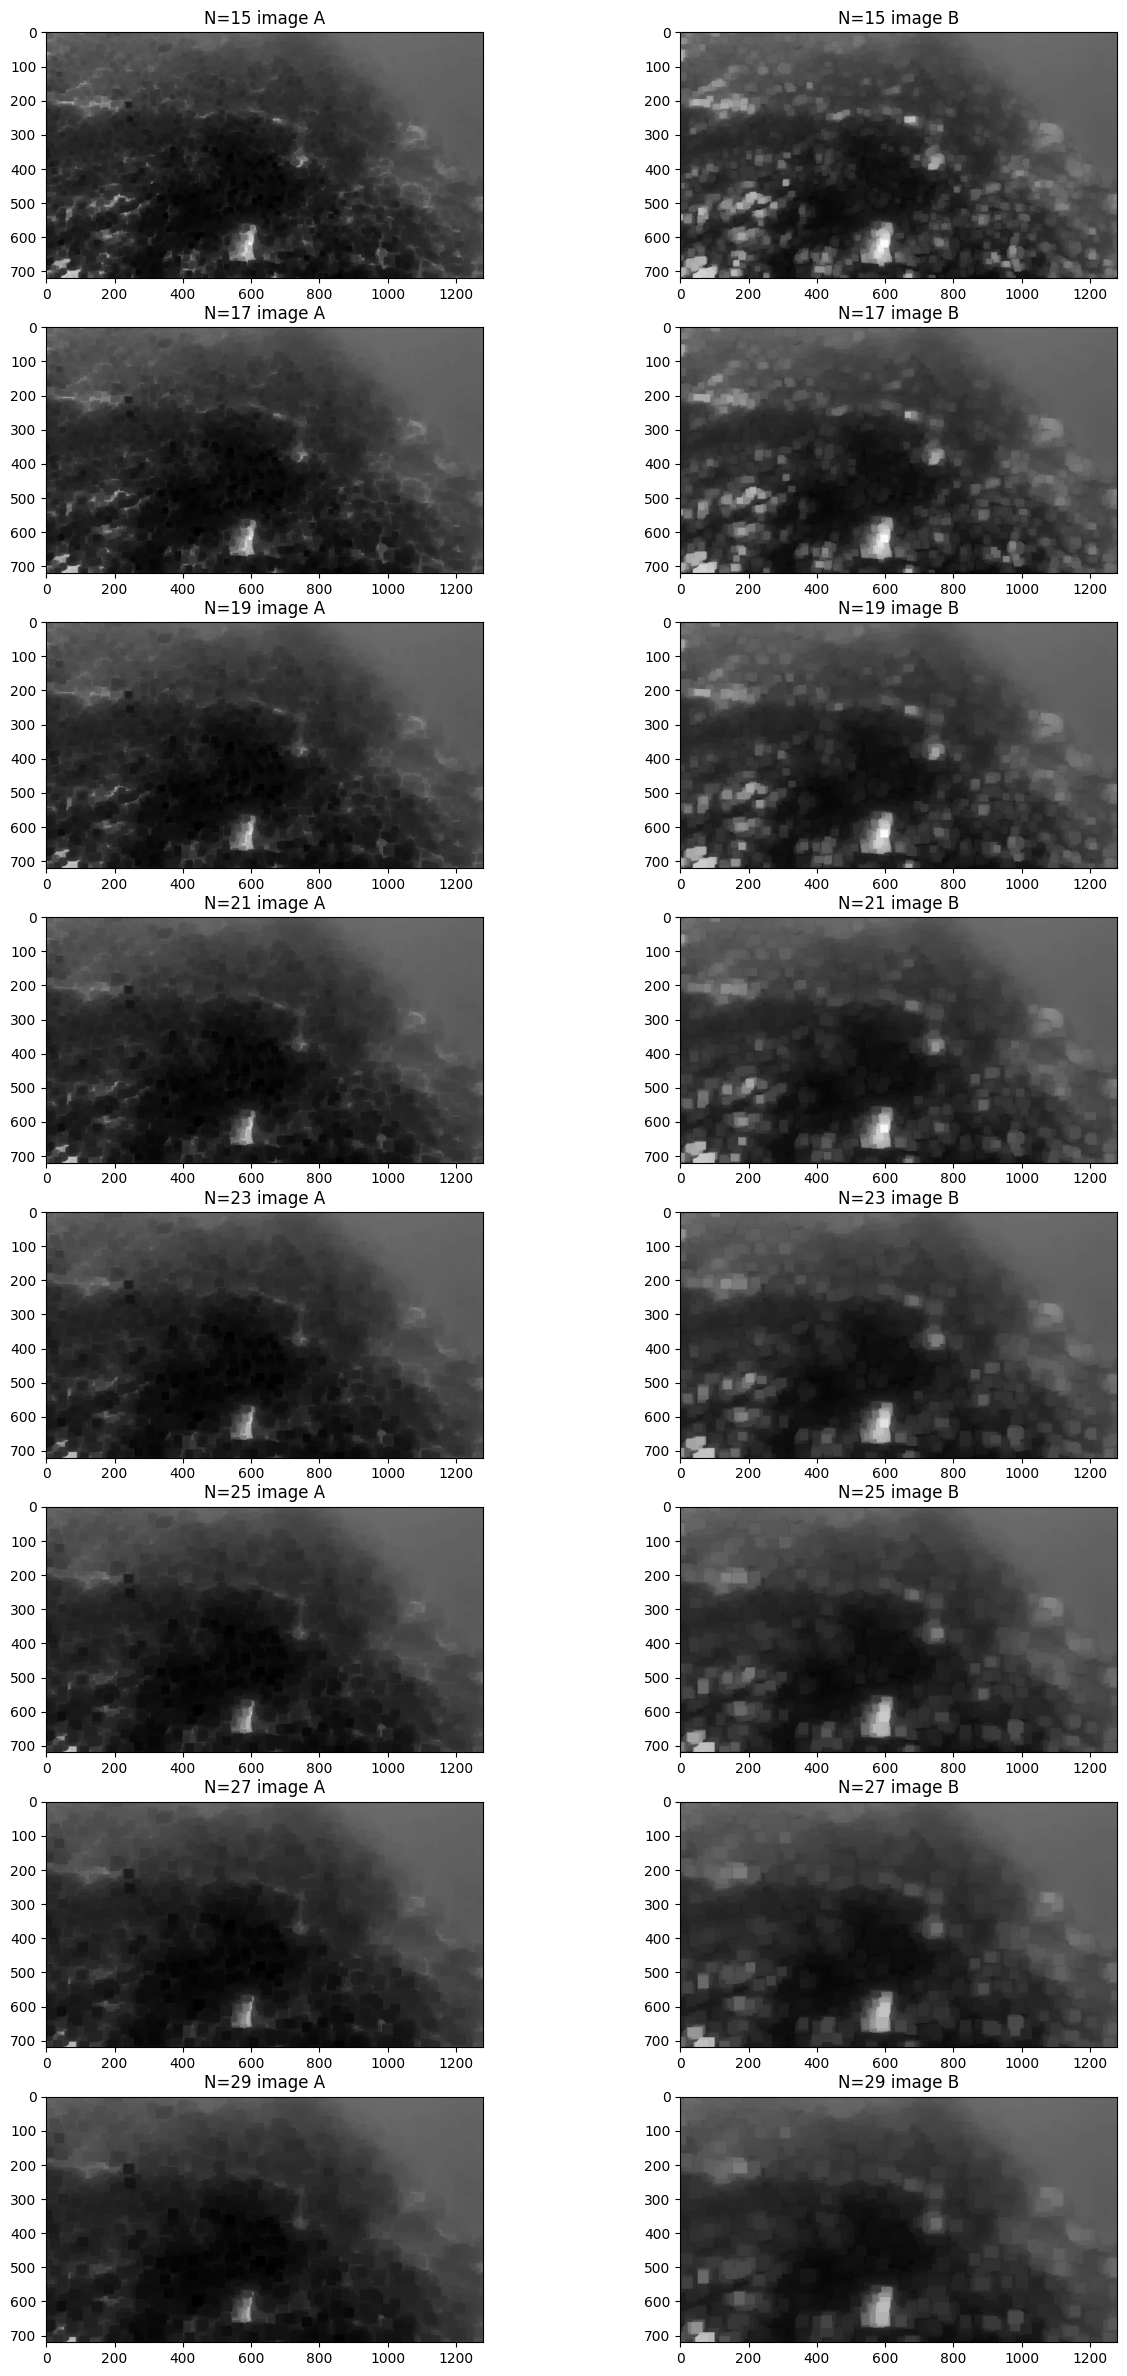

In [ ]:
fig = plt.figure(figsize=(15, 30))

index = 1
for images, N, index in zip(result, range(15, 30, 2), range(1, 16, 2)):
    img_A, img_B = images
    ax1 = fig.add_subplot(8, 2, index)
    ax1.set_title(f'{N=} image A')
    plt.imshow(img_A, cmap='gray', vmin=0, vmax=255)
    
    ax2 = fig.add_subplot(8, 2, index+1)
    ax2.set_title(f'{N=} image B')
    plt.imshow(img_B, cmap='gray', vmin=0, vmax=255)

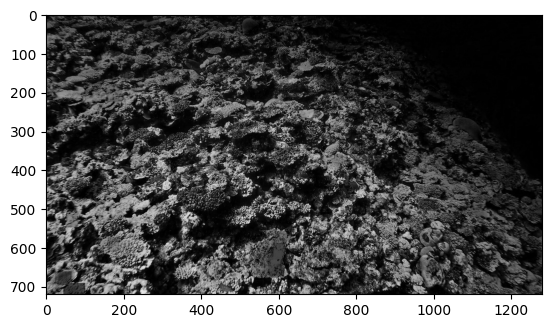

In [ ]:
# N = 29
image_O = np.zeros_like(contrast)

for r in range(row):
    for c in range(col):
        image_O[r,c] = contrast[r, c] - result[-1][1][r, c]
        

plt.imshow(image_O, cmap='gray', vmin=0, vmax=255)

In [ ]:
%timeit
f(11)

(array([[ 99.35064935,  99.35064935,  99.35064935, ..., 102.66233766,
         102.66233766, 102.66233766],
        [ 99.35064935,  99.35064935,  99.35064935, ..., 102.66233766,
         102.66233766, 102.66233766],
        [ 99.35064935,  99.35064935,  99.35064935, ..., 102.66233766,
         102.66233766, 102.66233766],
        ...,
        [ 80.58441558,  80.58441558,  80.58441558, ...,  76.16883117,
          76.16883117,  76.16883117],
        [ 80.58441558,  80.58441558,  80.58441558, ...,  76.16883117,
          76.16883117,  76.16883117],
        [ 80.58441558,  80.58441558,  80.58441558, ...,  76.16883117,
          76.16883117,  76.16883117]]),
 array([[ 99.35064935,  99.35064935, 101.55844156, ..., 102.66233766,
         102.66233766, 102.66233766],
        [102.66233766, 102.66233766, 102.66233766, ..., 102.66233766,
         102.66233766, 102.66233766],
        [102.66233766, 102.66233766, 102.66233766, ..., 102.66233766,
         102.66233766, 102.66233766],
        ...,


In [ ]:
def preprocess(N, PIL_image):
    gray_image = ImageOps.grayscale(PIL_image)
    np_gray = np.array(gray_image)

    var_a = 0
    var_b = 255

    var_c = np_gray.min()
    var_d = np_gray.max()

    def output(i: int) -> float:
        return (i - var_c) * ((var_b - var_a) / (var_d - var_c)) + var_a

    return np.array([[output(x) for x in row] for row in np_gray])

In [ ]:
new_images: np.ndarray = [preprocess(11, img) for img in imgs]

In [ ]:
"""小心内存爆了！ 我16gb内存 直接麻了"""

# export preprocessed image files
for index, row in df.iterrows():
    plt.imsave(row.export_image_path, new_images[index], cmap='gray')
    

<style>
    div{
        /* text-align: center; */
    }
    h2 {
        padding: 0;
        margin: 0;
        margin-bottom: 1rem;
        /* font-size: 6rem; */
        font-weight: bold;
        background: linear-gradient(to right, rgb(67, 124, 205), rgb(69, 214, 202));
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
    }
</style>
<div>
    <h2>Modeling</h2>
</div>

In [25]:
# ref: https://christianbernecker.medium.com/convert-bounding-boxes-from-coco-to-pascal-voc-to-yolo-and-back-660dc6178742
# Convert Coco bounding boxx to Yolo
def coco_to_yolo(x, y, width, height, image_w, image_h):
    return ((2 * x + width) / (2 * image_w)), ((2 * y + height) / (2 * image_h)), width / image_w, height / image_h

In [26]:
# export label files
for _, row in df.iterrows():
    with open(row.export_label_path, 'w') as label:
        for dict_ in row.annotations:
            # note that 0 stands for starfish
            class_id = 0
            center_x, center_y, width, height = coco_to_yolo(**dict_, image_w=WIDTH, image_h=HEIGHT)
            label.write(f"{class_id} {center_x} {center_y} {width} {height}\n")


In [27]:
# TODO: export cots.yaml file
import yaml
import os

data = dict(
    # windows
    train = os.path.join(os.getcwd(), 'dataset\\train'),
    val = os.path.join(os.getcwd(), 'dataset\\valid'),
    
    # # unix
    # train = os.path.join(os.getcwd(), 'dataset/train'),
    # val = os.path.join(os.getcwd(), 'dataset/valid'),
    
    nc = 1,
    names = ['cots'],
    path = os.getcwd()
)

with open('cots.yaml', 'w') as f:
    yaml.dump(data, f)

In [28]:
# modify yolov5s yaml config file
config = """# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
"""
with open('yolov5s.yaml', 'w', encoding='utf-8') as f:
    f.write(config)


In [ ]:
# train model with gpu 0
!python .\yolov5\train.py --device 0 --img 640 --batch 16 --epochs 5 --data ./cots.yaml --cfg ./yolov5s.yaml --weights ./yolov5s.pt

In [ ]:
for iou in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]:
    !python .\yolov5\val.py --weights yolov5\runs\train\exp17\weights\best.pt --data ./cots.yaml --img 640 --iou {iou}

<style>
    div{
        /* text-align: center; */
    }
    h2 {
        padding: 0;
        margin: 0;
        margin-bottom: 1rem;
        /* font-size: 6rem; */
        font-weight: bold;
        background: linear-gradient(to right, rgb(67, 124, 205), rgb(69, 214, 202));
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
    }
</style>
<div>
    <h2>Results</h2>
</div>

<!-- https://towardsdatascience.com/is-f1-the-appropriate-criterion-to-use-what-about-f2-f3-f-beta-4bd8ef17e285 -->
ref: https://towardsdatascience.com/is-f1-the-appropriate-criterion-to-use-what-about-f2-f3-f-beta-4bd8ef17e285
![](https://miro.medium.com/max/720/1*sZnpnbirEGmOhW4eupzliw.jpeg)
![](https://miro.medium.com/max/640/1*MVi_5xk41MTtgHdmW9S-mQ.jpeg)

In [2]:
# display results
# note that result.csv is manually typed in by reading the confusion matrix from each yolo validation results
df = pd.read_csv('result.csv')
df

iou    tp  fp    fn  tn        f2
0   0.30  0.29   1  0.71   0  0.274102
1   0.35  0.29   1  0.71   0  0.274102
2   0.40  0.29   1  0.71   0  0.274102
3   0.45  0.29   1  0.71   0  0.274102
4   0.50  0.29   1  0.71   0  0.274102
5   0.55  0.29   1  0.71   0  0.274102
6   0.60  0.29   1  0.71   0  0.274102
7   0.65  0.29   1  0.71   0  0.274102
8   0.70  0.29   1  0.71   0  0.274102
9   0.75  0.30   1  0.70   0  0.283019
10  0.80  0.30   1  0.70   0  0.283019

In [4]:
average_f2 = df['f2'].mean()
average_f2

0.27572331336363637